# Probabilistic Programming

A Probabilistic Programming Language (PPL) is a computer language providing statistical modelling and inference functionalities, in order to reason about random variables, probability distributions and conditioning problems.

The **Bayesian method** is the natural approach to inference. It preserves the idea of uncertainty by interpreting probability as a measure of believability in an event.
Any PPL should be able to represent the key components of Bayesian inference:

- prior probability = degree of belief of event occurring before observing any evidence
- evidence = observed data
- likelihood = compatibility of the evidence with the given hypothesis
- posterior probability = updated belief given the evidence

<div> 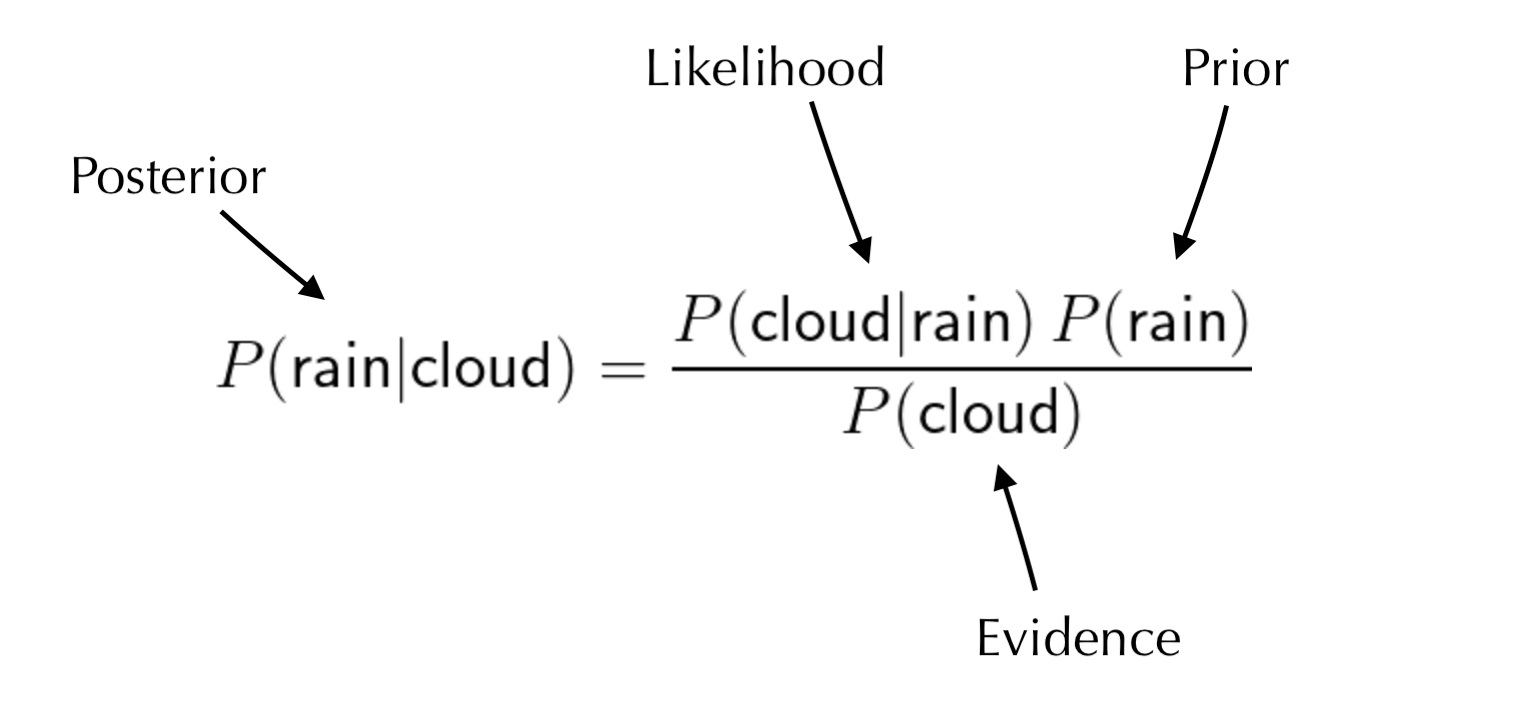</div>

[https://medium.com/informatics-lab/probabilistic-programming-1535d7882dbe](https://medium.com/informatics-lab/probabilistic-programming-1535d7882dbe)

<div> 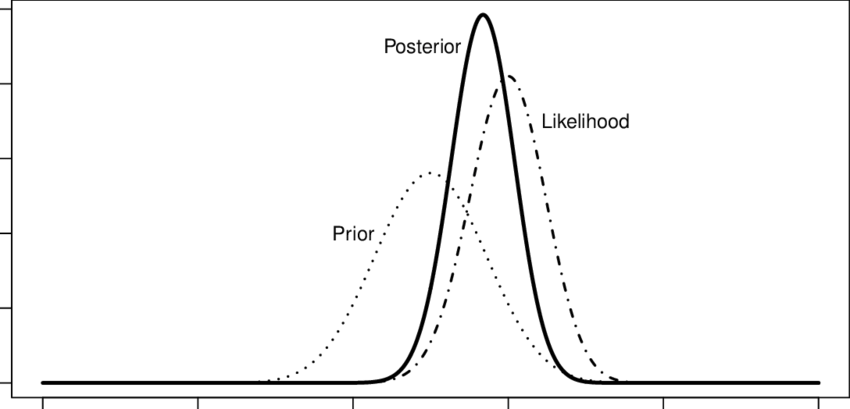</div>

[https://www.researchgate.net/figure/Bayesian-updating-of-the-prior-distribution-to-posterior-distribution-The-Posterior_fig1_320507985](https://www.researchgate.net/figure/Bayesian-updating-of-the-prior-distribution-to-posterior-distribution-The-Posterior_fig1_320507985)

A probabilistic program is a mix of **deterministic computation** and **sampling**, which allows to *draw random values* from distributions, *condition* variables on observations 
and perform *inference*.


## Pyro library
Pyro is a universal probabilistic programming language written in Python and supported by PyTorch on the backend.

Pyro can represent any probabilistic model, while providing automatic optimization-based inference that is flexible and scalable to large data sets. 
Pyro builds on PyTorch library, which supports GPU-accelerated tensor math and includes automatic differentiation, a technique for efficiently computing gradients.


In [3]:
import torch
import pyro
pyro.set_rng_seed(1)

### Models
The basic unit of probabilistic programs is the stochastic function (or model).

A stochastic function is an arbitrary Python callable that combines two ingredients:

- deterministic Python code
- primitive stochastic functions that call a random number generator

**`sample()` primitive** 

Drawing a sample from the unit normal distribution $\mathcal{N}(0,1)$.

In [4]:
loc = 0.  
scale = 1.

# using pytorch
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
x = normal.rsample() # draw a sample from N(0,1)
print("pytorch sample:\t", x)

# using pyro
x = pyro.sample("sample_name", pyro.distributions.Normal(loc, scale))

print("pyro sample:\t", x)

pytorch sample:	 tensor(0.6614)
pyro sample:	 tensor(0.2669)


Pyro samples are named: Pytorch backend uses these names to uniquely identify sample statements and change their behavior at runtime depending on how the enclosing stochastic function is being used.

**Drawing multiple samples**

We draw multiple samples from $\mathcal{N}(2,4)$ and plot the corresponding histogram.

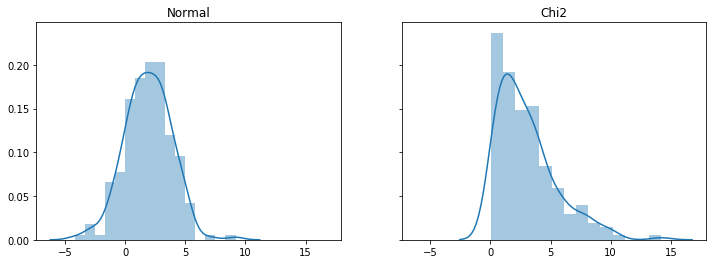

In [5]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pyro.distributions as dist

# distributions
normal =  dist.Normal(2, 2)
chi2 = dist.Chi2(3)

# multiple samples
normal_samples = [pyro.sample("n",normal) for i in range(200)]
chi2_samples = [pyro.sample("n",chi2) for i in range(200)]

#plot
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,4))
sns.distplot(normal_samples, ax=axes[0])
sns.distplot(chi2_samples, ax=axes[1])
axes[0].set_title('Normal')
axes[1].set_title('Chi2')
plt.show()

Seaborn `distplot()` automatically estimates the PDFs over histogram bins.

**A simple stochastic model**


Suppose we want to reason about how temperature interacts with sunny and cloudy weather. We can define a simple stochastic function `weather()` describing this interaction


$$ \mathcal{N}(12.0,5.0^2) \; \text{for cloudy weather}$$
 
$$\mathcal{N}(23.0,6.0^2) \; \text{for sunny weather} \; $$

In [6]:
def weather():
    # generate a binary sample
    is_cloudy = pyro.sample('cloudy', dist.Bernoulli(0.3))
    
    # convert binary sample into categorical
    is_cloudy = 'cloudy' if is_cloudy.item() == 1.0 else 'sunny'
    
    mean_temp = {'cloudy': 12.0, 'sunny': 23.0}[is_cloudy]
    scale_temp = {'cloudy': 5.0, 'sunny': 6.0}[is_cloudy]
    temp = pyro.sample('temp', dist.Normal(mean_temp, scale_temp))
    
    return {"weather":is_cloudy, "temp":temp.item()}

[weather() for _ in range(5)]

[{'weather': 'sunny', 'temp': 27.011775970458984},
 {'weather': 'cloudy', 'temp': 4.637136459350586},
 {'weather': 'cloudy', 'temp': 9.612428665161133},
 {'weather': 'cloudy', 'temp': 4.657132148742676},
 {'weather': 'sunny', 'temp': 18.160415649414062}]

We could use this stochastic function to model the sales of ice cream based on the weather.

In [7]:
def ice_cream_sales():
    is_cloudy, temp = weather()
    expected_sales = 200. if is_cloudy == 1 and temp > 35.0 else 20.
    sales = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.0))
    return sales

[ice_cream_sales() for _ in range(5)]

[tensor(29.7355),
 tensor(20.9674),
 tensor(13.2808),
 tensor(17.0347),
 tensor(30.8382)]

### Conditioning

Probabilistic programming allows us to condition generative models on observed data and to perform inference on it. In Pyro, we can separate the conditioning step from its evaluation via inference, write a model once and condition it on many different observations.

For example, we could build a model that estimates the weight of an object by using both a *prior knowledge* about the object and some *noisy measurement* informations.

$$weight \, | \, guess \sim \mathcal{N}(guess, 1)$$

$$ measurement \, | \, guess, weight \sim \mathcal{N}(weight, 0.75^2) $$

We first define the stochastic function:

In [8]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    measurement = pyro.sample("measurement", dist.Normal(weight, 0.75))
    return measurement

scale(5.)

tensor(6.8047)

Suppose that we observe a measurement of the object corresponding to 14 kg. We want to sample from the distribution of the weight given both the observation and an input knowledge `guess = 8.5`. In other words, we wish to infer the distribution 

$$weight \, | \, guess, measurement=9.5 \sim ?$$

Pyro provides a method called `pyro.condition` that takes a model and a dictionary of observations and returns a new model which is fixed on the measurement observation.

In [9]:
# using condition() method
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

`conditioned_scale()` model could be equivalently defined as follows:

In [10]:
# using obs parameter
def conditioned_scale(guess): 
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    measurement = pyro.sample("measurement", dist.Normal(weight, 1.), obs=9.5)
    return measurement

**Approximate inference**

Notice that in this simple example we could derive the posterior distribution of interest analytically, but in most cases its computation becomes intractable and we need to rely on approximation techniques.

Now that we have conditioned on an observation of measurement, we can use approximate inference algorithms to **estimate the posterior distribution**. This is an example of how you would write a posterior distribution on the conditioned scale model using Importance Sampling:

In [11]:
posterior = pyro.infer.Importance(conditioned_scale, num_samples=1000)

Approximate inference methods will be explored during the next lessons.

## References
- [Pyro library](https://pyro.ai/)
- [Pyro documentation](https://docs.pyro.ai/en/1.1.0/index.html)
- [Probabilistic Programming & Bayesian Methods for Hackers](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)